In [1]:
import matplotlib.pyplot as plt
import pandas as p
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import linregress
from scipy.spatial import distance
from matplotlib import colors
import scipy
import sys
import os
from matplotlib.backends.backend_pdf import PdfPages
# from sklearn.decomposition import PCA
from ast import literal_eval
from Bio import SeqIO
from itertools import combinations

%load_ext autoreload
%autoreload 2 

atish_assay_path = '../FitnessMeasurements/fitness_assay_grantedits.py'
sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
import fitness_assay_grantedits as atish

sns.set_color_codes()
sns.set_style('white')
sns.set_style('ticks')

In [4]:
merged_fitness = p.read_csv('../2%5%_FitnessMeasurement/EvolvingFront_2%5%FitnessMeasurementData.csv')

In [9]:
barcode_list = p.read_csv('../FitnessMeasurements/barcodes_previous+new.csv')
metagrid_calls = p.read_csv('../Metagrid/metagrid_calls_withLane3_redo.csv')

In [15]:
benomyl_calls = p.read_csv('BenoymlTest_Grades.csv')
benomyl_calls = benomyl_calls.replace(np.nan,'n')

ploidy = []
for call in benomyl_calls['diploid?'].values:
    if call == 'y':
        ploidy.append('diploid')
    elif call == 'n':
        ploidy.append('haploid')
    elif call == '?':
        ploidy.append('?')
    else:
        print('panic!')

benomyl_calls['ploidy'] = ploidy

In [22]:
unique_bcs = np.unique([bc for bc in metagrid_calls['barcode'].values if not p.isnull(bc)])

In [41]:
benomyl_dict = {}

call_freq_list = []

for bc in unique_bcs:
    this_bc = metagrid_calls[metagrid_calls['barcode']==bc]
    
    these_wells = this_bc['well'].values
    
    these_calls = benomyl_calls[benomyl_calls['full_name'].isin(these_wells)]
    
    ploidys = these_calls['ploidy'].values
    
    n_haploid_calls = np.sum([1 if ploidy=='haploid' else 0 for ploidy in ploidys])
    n_diploid_calls = np.sum([1 if ploidy=='diploid' else 0 for ploidy in ploidys])
    n_unknown_calls = np.sum([1 if ploidy=='?' else 0 for ploidy in ploidys])
    
    total_calls_made = n_haploid_calls + n_diploid_calls
    
    total_calls = n_haploid_calls + n_diploid_calls + n_unknown_calls
    
    call_freq_list.append((n_haploid_calls,n_diploid_calls,total_calls_made,n_unknown_calls))
    
    if total_calls_made > 0:
        # make the call if more than 2/3 of the called wells have the same ploidy
        if n_haploid_calls > 0.67*total_calls_made:
            this_call = 'haploid'
        elif n_diploid_calls > 0.67*total_calls_made:
            this_call = 'diploid'
        else:
            print(bc,n_haploid_calls,n_diploid_calls,total_calls_made,n_unknown_calls)
            this_call = '?'
        
    else:
        this_call = '?'
    
    benomyl_dict[bc] = this_call
    
    
    

ATCACAATAACTAAACTGATTCTTCA_AATTGAACTGAGAATTCACTTCAGCC 1 1 2 0
ATCACAATAACTAAACTGATTCTTCA_ACCTAAAACCGGAACTTTTTTATGGT 1 1 2 0
ATCACAATAACTAAACTGATTCTTCA_ACTGGAAATCCCAATCAATTTGAAGG 1 1 2 0
ATCACAATAACTAAACTGATTCTTCA_ATATGAAAAGAGAATCACTTTTTGGC 1 1 2 1
ATCACAATAACTAAACTGATTCTTCA_CAGGGAATCTCTAAGCTAGTTTGATC 4 4 8 1
ATCACAATAACTAAACTGATTCTTCA_CGTTTAAAAACTAATCAAATTCGAGT 2 1 3 0
ATCACAATAACTAAACTGATTCTTCA_CTAAGAAAAATTAATCTCATTATTGC 1 1 2 0
ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAATTCAAAT 121 160 281 43
ATCACAATAACTAAACTGATTCTTCA_GATATAAGGGGGAAGTGCGTTCCGGG 1 1 2 1
ATCACAATAACTAAACTGATTCTTCA_GTGGGAATACTTAAATGTTTTGCGCG 1 1 2 0
ATCACAATAACTAAACTGATTCTTCA_TCGGGAAACCGCAACATCCTTTGCTA 4 2 6 1
ATCACAATAACTAAACTGATTCTTCA_TTCGGAATTAAAAACTCGGTTGTTGC 2 2 4 0
ATCACAATAACTAAACTGATTCTTCA_TTCTTAACTTCTAAAAGTATTATGTG 3 3 6 0
CATTGAATCACAAAATAGGTTAGATG_TGTTAAACCCATAAATTCGTTTGGCG 1 1 2 0
CCAACAAAACACAAATCTGTTGTGTA_AAAAGAAGAGTTAACTTTGTTTCCGC 1 2 3 0
CCAACAAAACACAAATCTGTTGTGTA_ACAAAAACAACAAATATAGTTCTCTA 1 2 3 0
C

In [65]:
re_array_lists = ['ReArray_EVO1D_IRAs_list.csv',
                  'ReArray_EVO1D_TCG_list.csv',
                  'ReArray_EVO2D_IRA1_MIS_list.csv',
                  'ReArray_EVO2D_IRA1_NON_list.csv',
                  'ReArray_EVO3D_IRA1_MIS_list.csv',
                  'ReArray_EVO3D_IRA1_NON_list.csv',
                  'ReArray_EVO3D_TCG_list.csv']

# merged_rearray_list = []
merged_rearray = p.read_csv(f'../metagrid/rearray/{re_array_lists[0]}')

for this_list in re_array_lists[1:]:
    new_rearray = p.read_csv(f'../metagrid/rearray/{this_list}')
    merged_rearray = p.merge(merged_rearray,new_rearray,how='outer')
    

In [67]:
ploidy_list  = []

for bc in merged_rearray['barcode'].values:
    ploidy = benomyl_dict[bc]
    
    ploidy_list.append(ploidy)
    
merged_rearray['ploidy'] = ploidy_list

In [69]:
merged_rearray.to_csv('EvolvingFront_rearray_map_with_ploidy.csv',index=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(0, 50)

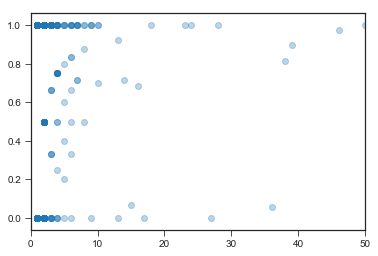

In [53]:
plt.scatter(call_freq_list[:,2],call_freq_list[:,0]/call_freq_list[:,2],alpha=0.3)
plt.xlim(0,50)

In [59]:
# benomyl_dict = {}

call_freq_list = []

for bc in unique_bcs:
    this_bc = metagrid_calls[metagrid_calls['barcode']==bc]
    
    these_wells = this_bc['well'].values
    
    these_calls = benomyl_calls[benomyl_calls['full_name'].isin(these_wells)]
    
    ploidys = these_calls['ploidy'].values
    
    n_haploid_calls = np.sum([1 if ploidy=='haploid' else 0 for ploidy in ploidys])
    n_diploid_calls = np.sum([1 if ploidy=='diploid' else 0 for ploidy in ploidys])
    n_unknown_calls = np.sum([1 if ploidy=='?' else 0 for ploidy in ploidys])
    
    total_calls_made = n_haploid_calls + n_diploid_calls
    
    total_calls = n_haploid_calls + n_diploid_calls + n_unknown_calls
    
    call_freq_list.append((n_haploid_calls,n_diploid_calls,total_calls_made,n_unknown_calls))
    
    if total_calls_made > 0:
        # make the call if more than 2/3 of the called wells have the same ploidy
        if n_haploid_calls > 0.67*total_calls_made:
            if n_haploid_calls < total_calls_made:
                print(bc,n_haploid_calls,n_diploid_calls,total_calls_made,n_unknown_calls)
                print(these_calls[['full_name','ploidy']])
        
#             this_call = 'haploid'
#         elif n_diploid_calls > 0.67*total_calls_made:
#             this_call = 'diploid'
#         else:
#             print(bc,n_haploid_calls,n_diploid_calls,total_calls_made,n_unknown_calls)
#             this_call = '?'
        
#     else:
#         this_call = '?'
    
#     benomyl_dict[bc] = this_call
    
    
    

ATCACAATAACTAAACTGATTCTTCA_AACGCAAAACCGAAACGCGTTGCGTC 45 13 58 6
                             full_name   ploidy
5282   EVO3D_IRA1_NON_R2_T21_Plate1-A3  haploid
5290  EVO3D_IRA1_NON_R2_T21_Plate1-A11  haploid
5293   EVO3D_IRA1_NON_R2_T21_Plate1-B2  haploid
5316   EVO3D_IRA1_NON_R2_T21_Plate1-D1  haploid
5324   EVO3D_IRA1_NON_R2_T21_Plate1-D9  haploid
5327  EVO3D_IRA1_NON_R2_T21_Plate1-D12  haploid
5351  EVO3D_IRA1_NON_R2_T21_Plate1-F12  haploid
5360   EVO3D_IRA1_NON_R2_T21_Plate1-G9  haploid
5361  EVO3D_IRA1_NON_R2_T21_Plate1-G10  haploid
5383   EVO3D_IRA1_NON_R2_T21_Plate2-A8  haploid
5385  EVO3D_IRA1_NON_R2_T21_Plate2-A10  haploid
5386  EVO3D_IRA1_NON_R2_T21_Plate2-A11  haploid
5387  EVO3D_IRA1_NON_R2_T21_Plate2-A12  haploid
5391   EVO3D_IRA1_NON_R2_T21_Plate2-B4  haploid
5392   EVO3D_IRA1_NON_R2_T21_Plate2-B5  haploid
5396   EVO3D_IRA1_NON_R2_T21_Plate2-B9  haploid
5397  EVO3D_IRA1_NON_R2_T21_Plate2-B10  haploid
5411  EVO3D_IRA1_NON_R2_T21_Plate2-C12  haploid
5428   EVO3D_IRA1_NON_R

ATCACAATAACTAAACTGATTCTTCA_GGAGCAACCCGGAACGGGATTGCGAG 3 1 4 0
                             full_name   ploidy
5438   EVO3D_IRA1_NON_R2_T21_Plate2-F3  haploid
5455   EVO3D_IRA1_NON_R2_T21_Plate2-G8  haploid
5505  EVO3D_IRA1_NON_R2_T21_Plate3-C10  haploid
5907   EVO3D_IRA1_NON_R3_T21_Plate2-E4  diploid
ATCACAATAACTAAACTGATTCTTCA_GTCAAAAATTCCAAACATCTTCATTC 3 1 4 0
                             full_name   ploidy
5335   EVO3D_IRA1_NON_R2_T21_Plate1-E8  haploid
5371   EVO3D_IRA1_NON_R2_T21_Plate1-H8  haploid
5764   EVO3D_IRA1_NON_R3_T21_Plate1-A5  diploid
5818  EVO3D_IRA1_NON_R3_T21_Plate1-E11  haploid
ATCACAATAACTAAACTGATTCTTCA_TATCAAAATTATAATACTATTGGATA 3 1 4 0
                             full_name   ploidy
5486   EVO3D_IRA1_NON_R2_T21_Plate3-B3  haploid
5508   EVO3D_IRA1_NON_R2_T21_Plate3-D1  haploid
5537   EVO3D_IRA1_NON_R2_T21_Plate3-F6  haploid
5794  EVO3D_IRA1_NON_R3_T21_Plate1-C11  diploid
CCAACAAAACACAAATCTGTTGTGTA_AACGCAAGAGGTAAGGGGATTGGGTG 3 1 4 0
                             ful

GACAGAAAAGCCAAATGGATTTACCG_AGTTAAAGCCCGAAAGCGGTTAGCTT 7 3 10 0
                       full_name   ploidy
6242  EVO3D_TCG_R1_T21_Plate1-A3  haploid
6252  EVO3D_TCG_R1_T21_Plate1-B1  haploid
6282  EVO3D_TCG_R1_T21_Plate1-D7  haploid
6348  EVO3D_TCG_R1_T21_Plate2-B1  haploid
6387  EVO3D_TCG_R1_T21_Plate2-E4  diploid
6470  EVO3D_TCG_R1_T21_Plate3-D3  haploid
6495  EVO3D_TCG_R1_T21_Plate3-F4  haploid
6604  EVO3D_TCG_R1_T21_Plate4-G5  diploid
6672  EVO3D_TCG_R1_T21_Plate5-E1  haploid
6692  EVO3D_TCG_R1_T21_Plate5-F9  diploid
GACAGAAAAGCCAAATGGATTTACCG_TATGAAACCGCGAACAACTTTGTGTA 5 2 7 0
                        full_name   ploidy
6303   EVO3D_TCG_R1_T21_Plate1-F4  haploid
6443  EVO3D_TCG_R1_T21_Plate3-A12  diploid
6519   EVO3D_TCG_R1_T21_Plate3-H4  diploid
6532   EVO3D_TCG_R1_T21_Plate4-A5  haploid
6547   EVO3D_TCG_R1_T21_Plate4-B8  haploid
6555   EVO3D_TCG_R1_T21_Plate4-C4  haploid
6557   EVO3D_TCG_R1_T21_Plate4-C6  haploid
TATCGAAACCCAAAGAGATTTAATCG_AACTAAATCGGGAACACTGTTTAAAT 45 1 46 0
     